## Image Clustering for Labeling

In [1]:
#!pip install keras

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, DataFrameIterator
from keras.preprocessing.image import DirectoryIterator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

2023-07-08 20:42:05.925641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 20:42:05.990628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 20:42:05.991827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 20:42:07.103598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

In [4]:
#!pip install openpyxl
import openpyxl

In [5]:
from google.cloud import storage

In [6]:
from tqdm import tqdm

In [7]:
import io

### Data Preprocessing

In [8]:
metadata_df = pd.read_excel('Labeling Checklist.xlsx')
metadata_df['ext'] = metadata_df['Folder'].astype(str) + '/' + metadata_df['File']
metadata_df = metadata_df.iloc[2:]
filedir_df = metadata_df[['ext']]

filedir_df.head()

,ext
2,328/644-0.jpg
3,328/656-0.jpg
4,328/720-0.jpg
5,328/779-0.jpg
6,328/780-0.jpg


In [15]:
metadata_df.head()

,id,manifestid,documentid,Full,uploaddatetimejsonmetadata,Folder,File,LABEL,SIGN OUT,ALLIGATOR,CATEGORY 1,CATEGORY 2,CATEGORY 3,POOR QUALITY,NOTES,onpremfilepathjsonmetadata,Unnamed: 16,Unnamed: 17,ext
2,180426,43417541,83328644,True,2023-04-07 07:25:00,328,644-0.jpg,Vogt,2023-04-29,False,pass,NaN,NaN,False,NaN,\\\\offtffs01\\Transflo\\Storage\\LHTRAILER\\C...,1,<-- % Complete,328/644-0.jpg
3,180429,43418071,83328656,False,2023-04-07 07:26:00,328,656-0.jpg,Vogt,2023-04-29,False,dunnage,NaN,NaN,False,NaN,\\\\offtffs01\\Transflo\\Storage\\LHTRAILER\\C...,NaN,NaN,328/656-0.jpg
4,180421,43416911,83328720,False,2023-04-07 07:24:00,328,720-0.jpg,Vogt,2023-04-29,False,pass,NaN,NaN,False,NaN,\\\\offtffs01\\Transflo\\Storage\\LHTRAILER\\C...,NaN,NaN,328/720-0.jpg
5,180420,43416841,83328779,True,2023-04-07 07:24:00,328,779-0.jpg,Vogt,2023-04-29,True,airbag,NaN,NaN,False,NaN,\\\\offtffs01\\Transflo\\Storage\\LHTRAILER\\C...,NaN,NaN,328/779-0.jpg
6,180422,43416961,83328780,True,2023-04-07 07:24:00,328,780-0.jpg,Vogt,2023-04-29,False,pass,NaN,NaN,False,NaN,\\\\offtffs01\\Transflo\\Storage\\LHTRAILER\\C...,NaN,NaN,328/780-0.jpg


In [9]:
def load_image_from_gcs(bucket_name, folder_name, image_path):
    # Initialize the client
    client = storage.Client()

    # Get the bucket
    bucket = client.get_bucket(bucket_name)

    # Get the blob path
    blob_path = folder_name + image_path

    # Get the blob
    blob = bucket.blob(blob_path)

    # Download the blob's content
    content = blob.download_as_bytes()

    # Process the content as needed (e.g., convert to image array)
    image = Image.open(io.BytesIO(content))
    image = image.convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image) / 255.0

    return image

# Specify your bucket name and folder name
bucket_name = 'capstone-project-roadrunner'
folder_name = 'Photos_all/'

In [10]:
# Load the images
train_image = []
for path in tqdm(metadata_df["ext"]):
    image = load_image_from_gcs(bucket_name, folder_name, path)
    train_image.append(image)

100%|██████████| 5000/5000 [19:16<00:00,  4.32it/s]


In [11]:
img = np.array(train_image)
print(img.shape)

(5000, 224, 224, 3)


### Extract Features

In [12]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [13]:
processed_images = preprocess_input(img.copy())
features = model.predict(processed_images)

157/157 [==============================] - 333s 2s/step


### Clustering based on 6 Categories

In [14]:
k = 6  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=42)

In [17]:
cluster_labels = kmeans.labels_

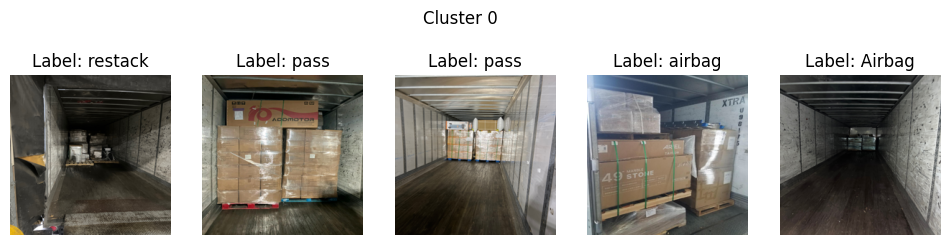

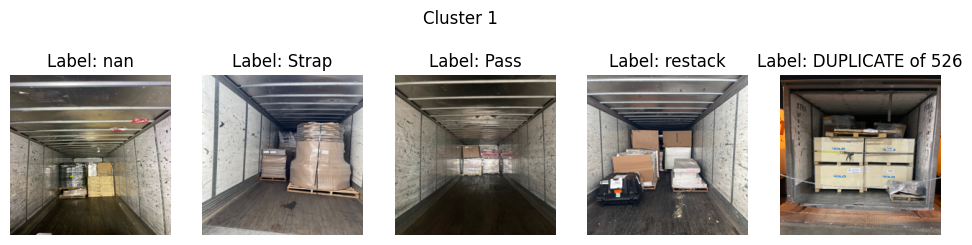

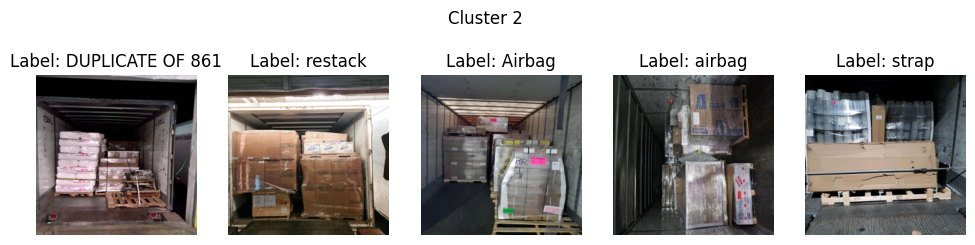

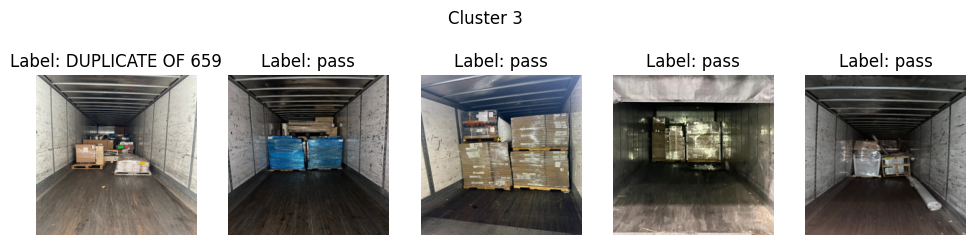

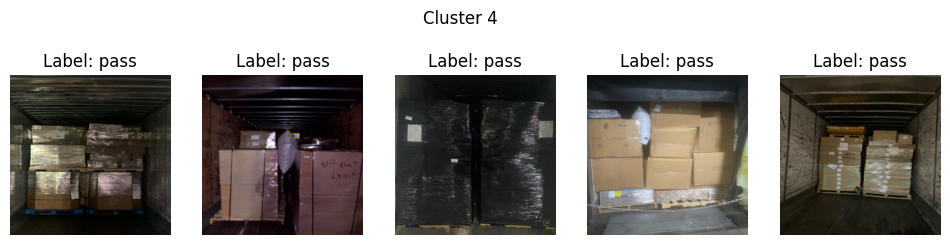

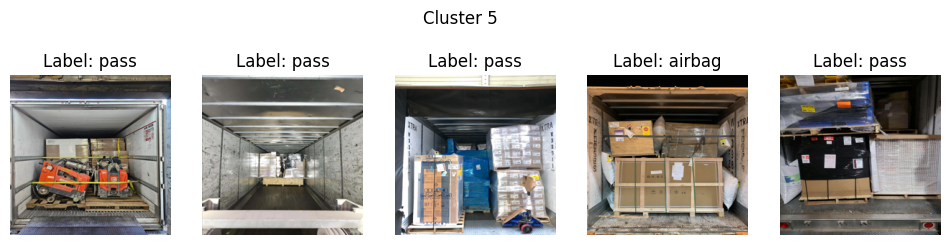

In [20]:
import matplotlib.pyplot as plt

num_images_per_cluster = 5

# Iterate over each cluster
for cluster_num in range(k):
    # Get the indices of images belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster_num)[0]

    # Randomly sample a few images from the cluster
    sampled_indices = np.random.choice(cluster_indices, size=num_images_per_cluster, replace=False)

    # Display the sampled images with original labels
    fig, axes = plt.subplots(1, num_images_per_cluster, figsize=(12, 3))
    fig.suptitle(f"Cluster {cluster_num}")

    for i, index in enumerate(sampled_indices):
        # Get the image from 'img' using the sampled index
        image = img[index]

        # Get the original label from 'metadata_df' using the sampled index
        original_label = metadata_df.loc[index, 'CATEGORY 1']

        # Display the image and original label
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {original_label}")
        axes[i].axis('off')

    plt.show()


### Clustering based on Good and Bad Image Quality

In [21]:
k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [22]:
cluster_labels = kmeans.labels_

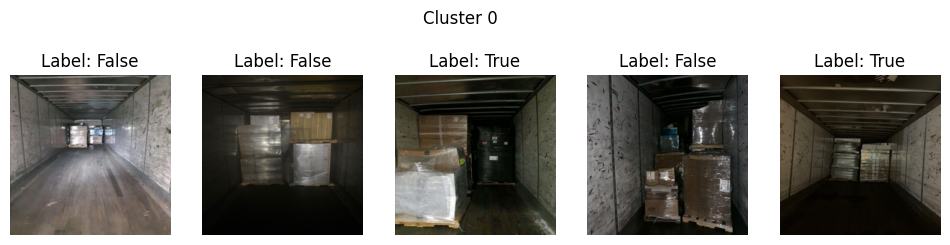

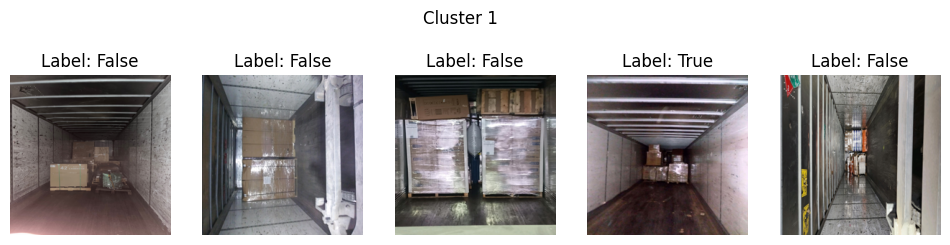

In [23]:
num_images_per_cluster = 5

# Iterate over each cluster
for cluster_num in range(k):
    # Get the indices of images belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster_num)[0]

    # Randomly sample a few images from the cluster
    sampled_indices = np.random.choice(cluster_indices, size=num_images_per_cluster, replace=False)

    # Display the sampled images with original labels
    fig, axes = plt.subplots(1, num_images_per_cluster, figsize=(12, 3))
    fig.suptitle(f"Cluster {cluster_num}")

    for i, index in enumerate(sampled_indices):
        # Get the image from 'img' using the sampled index
        image = img[index]

        # Get the original label from 'metadata_df' using the sampled index
        original_label = metadata_df.loc[index, 'POOR QUALITY']

        # Display the image and original label
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {original_label}")
        axes[i].axis('off')

    plt.show()